In [46]:
import numpy as np
import pandas as pd
import random     
import matplotlib.pyplot as plt
from scipy import optimize
np.random.seed(1)

## Bootstrapping
(Examples inspired from Section 5.2 of  ``` James, G., Witten, D., Hastie, T. & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: Springer.```)

### Motivation
Let us have two different stocks: $X$ and $Y$. Let they be normally distributed with the same mean such that $\mu_X := \mathbb{E}[X] = 2$ and $\mu_Y := \mathbb{E}[Y] = 2$. Furthermore, let $\sigma^2_X := \mathbb{V}\mathrm{AR}[X] = 1$, $\sigma^2_Y := \mathbb{V}\mathrm{AR}[Y] = 1.25$, and $\sigma_{XY} := \mathbb{C}\mathrm{OV}[X,Y] = 0.5$.

**Question 1:** How can we sample $1,000$ returns from these stocks?

**Answer:** See the code below.

In [47]:
n = 1000

# vector of means
mu = np.array([2 ,2])

# Described covariance matrix
r = np.array([
        [  1,    0.5],
        [ 0.5,  1.25]
    ])

# Generate the random samples.
returns = np.random.multivariate_normal(mu, r, size=n)

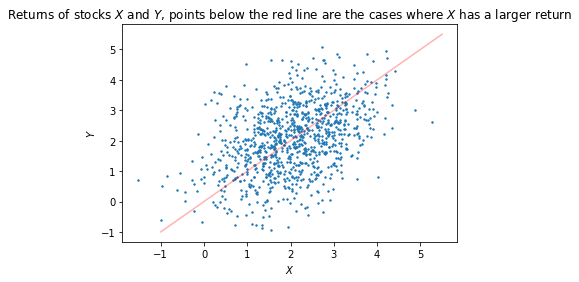

In [42]:
# Plot the returns
x = returns[:,0]
y = returns[:,1]
x1, y1 = [-1, 5.5], [-1, 5.5]
plt.plot(x1, y1, c = "r", alpha= .3)
plt.title(r"Returns of stocks $X$ and $Y$, points below the red line are the cases where $X$ has a larger return") 
plt.xlabel(r"$X$") 
plt.ylabel(r"$Y$") 
plt.scatter(x,y,s=2) 
plt.show()

**Question 2:** Let us invest a money on stocks $X$ and $Y$. We will invest a portion $\alpha \in [0,1]$ of our money on stock $X$, and the remaining $1 - \alpha$ on stock $Y$. Our goal is to minimize the risk of this investment, where we measure risk simply via variance in this case. In other words, we would like to solve:
$$\alpha^\star \in \arg\min_{\alpha} \{ \mathbb{V}\mathrm{AR}[\alpha X + (1-\alpha)Y] \}$$
How can find such an optimal $\alpha^\star$?

**Answer:** Recall that 
\begin{align*} \mathbb{V}\mathrm{AR}[\alpha X + (1-\alpha)Y] &= \alpha^2 \mathbb{V}\mathrm{AR}[X] + (1-\alpha)^2 \mathbb{V}\mathrm{AR}[Y] + 2\alpha(1-\alpha) \mathbb{C}\mathrm{OV}[X,Y]\\ 
& = \alpha^2 \sigma^2_X + (1-\alpha)^2 \sigma^2_Y + 2\alpha(1-\alpha) \sigma_{XY}
\end{align*}
Let us minimize this function by plugging in the true values of $\sigma_X^2 = 1,\  \sigma_Y^2 = 1.25, \ \sigma_{XY} = 0.5$ by using ```scipy optimize```. When we plug these values our problem is:
\begin{align*}
\begin{array}{ll}
\mathrm{minimize}_\alpha & (1-\alpha)^2 1.25 + \alpha \\
\mathrm{subject to} & \alpha \in [0,1].
 \end{array}
\end{align*}

In [9]:
def objective_given(alpha):
    """The objective function to minimize"""
    return (1-alpha)**2 * 1.25 + alpha
bounds = optimize.Bounds([0],[1])
solution = optimize.minimize(objective_given, x0 = [0], bounds = bounds)

In [10]:
print("The optimal solution is when alpha = ", round(float(solution.x),3))

The optimal solution is when alpha =  0.6


What if we keep $\sigma^2_X, \sigma^2_Y, \sigma_{XY}$ as parameters and change them whenever we want? So we want to directly solve
\begin{align*}
\begin{array}{ll}
\mathrm{minimize}_\alpha & \alpha^2 \sigma^2_X + (1-\alpha)^2 \sigma^2_Y + 2\alpha(1-\alpha) \sigma_{XY} \\
\text{subject to} & \alpha \in [0,1].
 \end{array}
\end{align*}

In [11]:
def objective_given(alpha, varx, vary, covar):
    """The objective function to minimize"""
    return (alpha**2 * varx) + ((1-alpha)**2 * vary) + (2*alpha*(1-alpha)*covar)
bounds = optimize.Bounds([0],[1])
solution = optimize.minimize(objective_given, x0 = [0], bounds = bounds, args=(1,1.25,0.5)) #this was previous case

In [12]:
print("The optimal solution is when alpha = ", round(float(solution.x),3))

The optimal solution is when alpha =  0.6


In [13]:
solution = optimize.minimize(objective_given, x0 = [0], bounds = bounds, args=(5,1.25,0.5))
print("The optimal solution is when alpha = ", round(float(solution.x),3))

The optimal solution is when alpha =  0.143


We can see that the larger $\sigma^2_X$ gets, the less we invest in $X$ as $\alpha$ decreases.

A common error in optimization practice is that in several cases we don't need to use an optimization solver, and derive the solution ourselves. If we can do that, one particular advantage would be, the structure of the optimal solution will be parametrized by $\sigma_X^2, \ \sigma_Y^2, \ \sigma_{XY}$. This will, in turn, allow us to have more intuition on the optimal investment strategy. Let's see how it works.

We can rewrite the objective function:
\begin{align*} \mathbb{V}\mathrm{AR}[\alpha X + (1-\alpha)Y] &= \alpha^2 \sigma^2_X + (1-\alpha)^2 \sigma^2_Y + 2\alpha(1-\alpha) \sigma_{XY} \\
& = \alpha^2 \sigma^2_X + \sigma^2_Y + \alpha^2 \sigma^2 Y - 2\alpha \sigma^2_Y + 2\alpha \sigma_{XY} - 2\alpha^2 \sigma_{XY} \\
& = \alpha^2(\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}) + 2\alpha(\sigma_{XY} - \sigma^2_Y) + \sigma_Y^2
\end{align*}
Notice that this is a quadratic function of $\alpha$, and the coefficient of $\alpha^2$ is $\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}$ which is $\mathbb{V}\mathrm{AR}[X - Y] \geq 0$. Hence, $\alpha^2$ has a coefficient term, concluding the objective function is **convex**. So if we take the first order conditions, then the solution that solves them is optimal. In other words:
\begin{align*}
\dfrac{\mathrm{d}\left[ \alpha^2(\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}) + 2\alpha(\sigma_{XY} - \sigma^2_Y) + \sigma_Y^2 \right]}{\mathrm{d} \alpha} = 2\alpha (\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}) + 2(\sigma_{XY} - \sigma^2_Y)
\end{align*}
Optimal $\alpha^\star$ sets the above expression equal to zero, hence it immediately follows that:
\begin{align*}
\alpha^\star = \dfrac{\sigma^2_Y - \sigma_{XY}}{\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}}.
\end{align*}
Let's test if this is correct now:

In [43]:
def optimal_alpha(varx, vary, covar):
    return (float) (vary - covar)/(varx + vary - 2*covar)
round(optimal_alpha(1, 1.25, 0.5),3)

0.6

In [44]:
round(optimal_alpha(5, 1.25, 0.5),3)

0.143

Wow! It is giving the previously optimized solutions. Please let us know your interpretation of this optimal investment strategy.

**Question 3:** In real life, we **never** know the distribution of stocks $X$ and $Y$. Hence we can only **estimate** $\sigma^2_X, \ \sigma^2_Y, \ \sigma_{XY}$ from a sample of $(X,Y)$ realizations. Let us have $n$ samples of $(X,Y)$, name them $(X_i, Y_i)$ for $i=1,\ldots,n$. So how can we decide the optimal investment strategy of the future, by looking at the **past data**? 

**Answer:** We estimate $\sigma_X^2$, $\sigma_Y^2$, $\sigma_{XY}$ by using the sample we are given. Let these estimates be $\hat{\sigma}_X^2, \ \hat{\sigma}_Y^2, \ \hat{\sigma}_{XY}$.

*Step 1: Estimate the mean returns $\bar{X}, \ \bar{Y}$ by*
\begin{align*}
\bar{X} &= \frac{1}{n}\sum_{i=1}^n X_i \\
\bar{Y} &= \frac{1}{n}\sum_{i=1}^n Y_i
\end{align*}

In [48]:
hat_mean = np.mean(returns,0)
print(hat_mean)

[1.95247227 1.97292093]


In [65]:
hat_cov = np.dot((returns - hat_mean).T, (returns - hat_mean))
hat_cov = hat_cov/(n-1)
hat_cov

array([[0.97695395, 0.50269434],
       [0.50269434, 1.30685668]])

*Step 2: Estimate the covariance matrix by*
\begin{align*}
\begin{bmatrix}
\hat{\sigma}^2_X & \hat{\sigma}_{XY} \\
\hat{\sigma}_{XY} & \hat{\sigma}^2_Y
\end{bmatrix} = \dfrac{1}{n-1} \sum_{i=1}^n \left( \begin{bmatrix} X_i & Y_i \end{bmatrix}^\top \begin{bmatrix} X_i & Y_i \end{bmatrix} \right)
\end{align*}

In [66]:
hat_cov = np.zeros((2,2))
for i in range(n):
    hat_cov = hat_cov + (returns[i]-hat_mean).reshape((2,1))*(returns[i]-hat_mean).reshape((1,2))
hat_cov = hat_cov/(n-1)
hat_cov

array([[0.97695395, 0.50269434],
       [0.50269434, 1.30685668]])

In [76]:
hat_varx = hat_cov[0,0]
hat_vary = hat_cov[1,1]
hat_covar = hat_cov[0,1]

*Step 3: Estimate $\alpha^\star$ by*
\begin{align*}
\hat{\alpha}^\star = \dfrac{\hat{\sigma}^2_Y - \hat{\sigma}_{XY}}{\hat{\sigma}^2_X + \hat{\sigma}^2_Y - 2\hat{\sigma}_{XY}}.
\end{align*}

In [51]:
round(optimal_alpha(hat_varx, hat_vary, hat_covar),3)

0.629

The real optimal strategy (if we really knew the distribution behind $(X,Y)$) would be $\alpha^\star = 0.6$, however, as we see $1,000$ samples, we can estimate $0.629$. Let us make a function that generalizes this process.

In [20]:
def generate_sample(n, varx=1, vary=1.25, covar=0.5): #generate a sample of n returns
    mu = np.array([2 ,2])
    r = np.array([
            [  varx, covar],
            [ covar,  vary]])
    sample_returns = np.random.multivariate_normal(mu, r, size=n)
    return sample_returns
def hat_alpha(sample_returns): #estimate the optimal investment strategy
    hat_mean = np.mean(sample_returns,0)
    hat_cov = np.zeros((2,2))
    n = np.size(sample_returns,0)
    for i in range(n):
        hat_cov = hat_cov + (sample_returns[i]-hat_mean).reshape((2,1))*(sample_returns[i]-hat_mean).reshape((1,2))
    hat_cov = hat_cov/(n-1)
    hat_varx = hat_cov[0,0]
    hat_vary = hat_cov[1,1]
    hat_covar = hat_cov[0,1]
    return round(optimal_alpha(hat_varx, hat_vary, hat_covar),3)

**Question 4:** How does our estimation change if we see different samples? Can it be that our estimation $\hat{\alpha}^\star$ is very different than the real $\alpha$ (which we don't see), but the specific sample of returns give us a huge bias?

In [21]:
simulation = 1000 #number of times to simulate
samples = 1000 #how many samples do we see in each "scenario"
estimations = np.zeros(simulation)
for sim in range(simulation):
    estimations[sim] = hat_alpha(generate_sample(samples))

In [22]:
print("mean", round(np.mean(estimations),3),"min",np.min(estimations), "max", np.max(estimations))

mean 0.601 min 0.528 max 0.686


As we can see, the mean of all estimations are equal to the true $\alpha$, which is the result of our unbiased estimation. However, our estimation vary between $[0.528, 0.686]$. How often do you think we have 'bad' values? Let's see in a histogram:

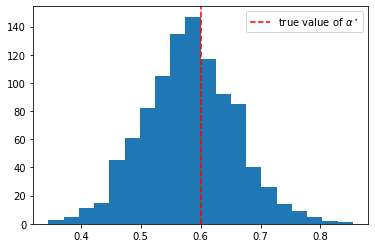

In [40]:
plt.hist(estimations,  bins = 20)  # density=False would make counts
plt.axvline(x=0.6, color='r', linestyle='--', label = r"true value of $\alpha^\star$")
plt.legend()
plt.show()

Previously, we had $1,000$ simulations, and in each simulation we had $1,000$ samples. In real-life, we rarely get such a big sample. What if we just have $100$ samples? Let's see the histogram again.

In [24]:
samples = 100 #how many samples do we see in each "scenario"
estimations = np.zeros(simulation)
for sim in range(simulation):
    estimations[sim] = hat_alpha(generate_sample(samples))
print("mean", round(np.mean(estimations),3),"min",np.min(estimations), "max", np.max(estimations))

mean 0.595 min 0.359 max 0.87


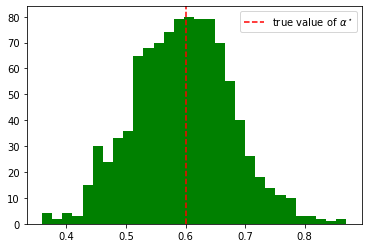

In [25]:
plt.hist(estimations,  bins = 30, color = 'g')  # density=False would make counts
plt.axvline(x=0.6, color='r', linestyle='--', label = r"true value of $\alpha^\star$")
plt.legend()
plt.show()

**Question 5:** In real life we are in a single 'simulation'. As we don't know the real distribution of data, we cannot generate $1,000$ samples and decide accordingly. We need to take the risk and trust on our $\hat{\alpha}^\star$ estimation. The question is, can we quantify this 'trust'? 

**Answer:** It turns out yes!!! Bootstrapping saves us here. Let us first see simple statistics of our previous simulation. As a step 1, let us denote the previous simulations by $B = 1,\ldots,1000$. Recall that in the very last experiment, in every simulation we generated a sample of $100$ returns of $(X,Y)$. What is the mean of our estimations $\hat{\alpha}_b$ (where $b \in \{ 1,\ldots, B\}$ is the simulation number)?

We get that via $\bar{\alpha} = \sum_{b=1}^B \hat{\alpha}_b$. Note that we drop the notation $\alpha^\star$ as it is clear that we are estimating the optimal $\alpha$. 

In [26]:
B = simulation #notational convenience
bar_alpha = np.mean(estimations)
round(bar_alpha,3)

0.595

Now let us compute the standard deviation of these estmates:

In [27]:
standard_error = np.sqrt( np.sum(np.square(estimations - bar_alpha)) /(B-1))
round(standard_error,3)

0.081

We have that our estimation satisfies $SE(\hat{\alpha}) \approx 0.081$ **based on the simulations**. So if we randomly sample $100$ returns of $(X,Y)$ just once, and estimate $\hat{\alpha}$ via the formula we derived, i.e.,
\begin{align*}
\hat{\alpha}^\star = \dfrac{\hat{\sigma}^2_Y - \hat{\sigma}_{XY}}{\hat{\sigma}^2_X + \hat{\sigma}^2_Y - 2\hat{\sigma}_{XY}}.
\end{align*}
then we expect this number to deviate from the *true optimal* $\alpha$, i.e., 
\begin{align*}
\alpha^\star = \dfrac{\sigma^2_Y - \sigma_{XY}}{\sigma^2_X + \sigma^2_Y - 2\sigma_{XY}}.
\end{align*}
by an amount of $0.082$ in average.

However, in the above experiments, we simulated a sampe of returns (of size $100$) for $1,000$ times. Such sampling requires us to use the distribution of $(X,Y)$. Again, in real life, we do **not** know the true distribution. We only have a single sample of $100$ returns of $(X,Y)$ and that is all we know. Let us denote the sample as $\mathcal{R} = \{(X_i, Y_i) \ : \ i = 1,\ldots,100 \}$.

So how can we apply the previous simulation? Here comes bootstrapping. The idea is simple: as before, we simulate $1,000$ times, and in each simulation we sample $100$ realizations of $(X,Y)$ returns. But, this time, we use the returns $\mathcal{R}$ we already have. However, if we sample $100$ distinct values, this is basically equivalent with the true set of returns we have. Instead, here, we sample **with replacements**. Let's see how it works now.

*Step 1: We are given a sample of $100$ returns and we do not know the true distribution.*

In [57]:
given_returns = np.random.multivariate_normal(mu, r, size=n)

*Step 2: We estimate the optimal investment strategy by estimating $\hat{\alpha}$ from the given returns.*

In [58]:
estimated_alpha = hat_alpha(given_returns)
estimated_alpha

0.65

*Step 3: We see the standard error associated with such estimation technique by using Bootstrapping*

In [61]:
simulation = 1000#same as before
B = simulation
samples = 100#same
estimations = np.zeros(simulation)#same as before 
for sim in range(simulation):
    generated_sample = given_returns[np.random.randint(given_returns.shape[0], size=samples), :]
    estimations[sim] = hat_alpha(generated_sample)
print("mean", round(np.mean(estimations),3),"min",np.min(estimations), "max", np.max(estimations))

mean 0.651 min 0.384 max 0.912


In [75]:
#compute standard error
bootstrap_error = np.std(estimations)
np.round(bootstrap_error,3)

0.08

In [73]:
help(np.var)

Help on function var in module numpy:

var(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)
    Compute the variance along the specified axis.
    
    Returns the variance of the array elements, a measure of the spread of a
    distribution.  The variance is computed for the flattened array by
    default, otherwise over the specified axis.
    
    Parameters
    ----------
    a : array_like
        Array containing numbers whose variance is desired.  If `a` is not an
        array, a conversion is attempted.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the variance is computed.  The default is to
        compute the variance of the flattened array.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, a variance is performed over multiple axes,
        instead of a single axis or all the axes as before.
    dtype : data-type, optional
        Type to use in computing the variance.  Fo

In [62]:
#compute standard error
bootstrap_error = np.sqrt( np.sum(np.square(estimations - np.mean(estimations))) /(B-1))
np.round(bootstrap_error,3)

0.08

In [32]:
print("The estimation of the standard error from the simulations when we knew the distribution (which is very close to the truth due to the law of large numbers) was", round(standard_error,3))
print("While the bootstrap estimation of the standard error is", round(bootstrap_error,3))
print("Boostrapping does not use any single information except for the given single 100-returns!")

The estimation of the standard error from the simulations when we knew the distribution (which is very close to the truth due to the law of large numbers) was 0.081
While the bootstrap estimation of the standard error is 0.076
Boostrapping does not use any single information except for the given single 100-returns!


**Question 6:** When we are given a single sample of $100$-returns and estimate $\hat{\alpha}$, how can we obtain a confidence interval of the true $\alpha$?

**Answer:** This answer is inspired by ```Professor Martin Haugh```'s lecture notes on ```Resampling Methods```.
Let us be interested in a $1-\beta$-Confidence Interval (CI) on the true $\alpha$. Fix any $\beta$.

In [33]:
beta = 0.1

Let $q_l, \ q_u$ be the $\beta/2$ lower and upper quantiles of the bootstrap samples.

In [34]:
ql = np.quantile(estimations, beta/2)
qu = np.quantile(estimations, 1- beta/2)

Then, the fraction of $\hat{\alpha}_b$ satisfying $q_l \leq \hat{\alpha}_b \leq q_u$ out of all $b=1,\ldots,B$ (where $B =1000$ in this case) is $1-  \beta$. Let's observe this:

In [35]:
collect = 0
for i in range(B):
    if estimations[i] <= qu and estimations[i] >= ql:
        collect += 1
collect/B

0.9

A naive approach is to claim $\alpha$ lies in the range $[q_l, q_u]$ which is a $1-\beta$ ($90\%$ in this case) confidence interval. Hence in our case (recall true $\alpha = 0.6$), our confidence interval is:

In [36]:
np.array([ql, qu])

array([0.45995, 0.71025])

However, we can improve this! Recall that $\bar{\alpha}$ is our estimation by using the whole sample of 100 returns. It is:

In [37]:
bar_alpha

0.594963

The estimations that satisfy $q_l \leq \hat{\alpha}_b \leq q_u$ also satisfy $\bar{\alpha} - q_u \leq \bar{\alpha} - \hat{\alpha}_b \leq \bar{\alpha} -q_l$. Hence, $\bar{\alpha} - q_u$ and $\bar{\alpha}- q_l$ are lower/upper $\beta/2$ quantiles for $\bar{\alpha} - \hat{\alpha}_b$!

So if we add $\bar{\alpha}$ to this equation, we will obtain: $2\bar{\alpha} - q_u \leq \alpha \leq 2\bar{\alpha}  - q_l$.

Thus, a $(1 - \beta)\%$ CI of the true $\alpha$ is $(2\bar{\alpha} - q_u, 2\bar{\alpha}  - q_l)$. In our case, a $90\%$ CI is:

In [38]:
np.array([2*bar_alpha - qu, 2*bar_alpha - ql])

array([0.479676, 0.729976])

Note that previously we observed that the minimum bootsrap estimate of the $\alpha$ was $0.35$ and the maximum was $0.85$, so we can observe how a $90\%$ CI is more compact.

**Exercise**
- How would you modify the estimation of $\alpha$, the simulation, and the Bootstrapping for obtaining CI, if you were told that $(X,Y)$ has a normal distribution?